# Final Project

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
def acc_loss(history, pdir):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['accuracy'], label='Training')
    ax1.plot(history['val_accuracy'], label='Validation')
    ax1.grid()
    ax1.set_title('Accuracy', fontsize=15)
    ax1.set_xlabel('epoch', fontsize=12)
    ax1.set_ylabel('accuracy', fontsize=12)
    ax1.legend(loc='top left')
    ax2.plot(history['loss'], label='Training')
    ax2.plot(history['val_loss'], label='Validation')
    ax2.grid()
    ax2.set_title('Loss', fontsize=15)
    ax2.set_xlabel('epoch', fontsize=12)
    ax2.set_ylabel('loss', fontsize=12)
    ax2.legend(loc='top left')
    fig.suptitle('Training result', fontsize=18)
    fig.savefig(pdir, bbox_inches='tight')

In [4]:
imgX, imgY, num_classes = 224, 224, 2

## image data generator: resize...etc.
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.15,
    rotation_range=10,
    zoom_range=0.1,
    validation_split=0.15    # validation split from training data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    directory='train',
    target_size=(imgX, imgY),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'    # originated from train_datagen set as「training data」.
)

val_generator = train_datagen.flow_from_directory(
    directory='train',
    target_size=(imgX, imgY),
    batch_size=1,
    class_mode='binary',
    shuffle=False,
    subset='validation'    ## originated from train_datagen set as「validation data」.
)

test_generator = test_datagen.flow_from_directory(
    directory='test', 
    target_size=(imgX, imgY),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
def model_result(predict, name, test=test_generator.classes):
    mat1 = confusion_matrix(test, predict)
    sns.heatmap(mat1.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=train_generator.class_indices,
                yticklabels=train_generator.class_indices, cmap="YlGnBu")
    accuracy = np.sum(test == predict) / len(test)
    plt.xlabel('Original', fontsize=14)
    plt.ylabel('Predicted', fontsize=14)
    plt.title(str(name) + ' ACC:' + str(round(accuracy,4)))
    plt.savefig('./images/' + name + '_result.png', bbox_inches='tight')
    tn, fp, fn, tp = confusion_matrix(test, predict).ravel()
    recall  = round((tp / (tp + fn)), 4) # sensitivity
    precision  = round((tn / (tn + fp)), 4) # specificity
    f1 = round((2 / (1/recall + 1/precision)), 4)
    report = {name: [accuracy, recall, precision, f1]}
    report = pd.DataFrame(report, index=['Accuracy', 'Recall', 'Precision', 'F1'])
    print(report)

# References:

https://www.tensorflow.org/guide/keras/save_and_serialize

https://blog.csdn.net/weixin_30826761/article/details/95509779

https://blog.csdn.net/sinat_26917383/article/details/72859145

https://blog.csdn.net/sunbaigui/article/details/50807418

https://blog.csdn.net/langb2014/article/details/52787095

https://blog.csdn.net/cv_family_z/article/details/50789805

https://blog.csdn.net/qq_36330643/article/details/77367709

https://blog.csdn.net/wmy199216/article/details/71171401 

https://blog.csdn.net/weixin_41967600/article/details/105616647#GoogleNet%C2%A0

https://keras-cn.readthedocs.io/en/latest/other/application/

https://gist.github.com/baraldilorenzo/8d096f48a1be4a2d660d

In [6]:
from numba import cuda
cuda.select_device(0)
cuda.close()

##### 關於BFC算法：
##### 將內存分塊管理，按塊進行空間分配和釋放。
##### 通過split操作將大內存塊分解成用戶需要的小內存塊。
##### 通過merge操作合併小的內存塊，做到內存碎片回收
##### 通過bin這個抽象數據結構實現對空閒塊高效管理。

In [7]:
from keras.backend.tensorflow_backend import set_session

config=tf.compat.v1.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
tf.compat.v1.keras.backend.set_session(config)

### AlexNet

In [9]:
model = Sequential()
model.add(Conv2D(96, (11, 11), strides=(4, 4), input_shape=(224, 224, 3), padding='valid',
                 activation='relu', kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), strides=(1, 1), padding='same',activation='relu', kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))

model.add(BatchNormalization())
#     model.add(Dense(512, activation='sigmoid'))
#     model.add(Dropout(0.25))
#     model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=[tf.keras.metrics.binary_crossentropy, 'accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 256)      

In [10]:
np.random.seed(101)
model_ckpt = ModelCheckpoint('./models/Alexnet_32.h5', monitor='val_acc', save_best_only=True)

# set_session(tf.Session(config=config))
start = time.time()

model_alexnet = model.fit(train_generator,
                          epochs=15,
                          validation_data=val_generator,
                          callbacks=[model_ckpt])
end = time.time()

print('\nAlexNet: {0} seconds.'.format(end - start))
model.save('./models/Alexnet_32_last.h5')

history_alexnet = pd.DataFrame(model_alexnet.history)
with open('./history/Alexnet_32_hist.json', 'w') as f:
    history_alexnet.to_json(f)

Epoch 1/15
139/139 [==============================] - 182s 1s/step - loss: 0.6200 - binary_crossentropy: 0.6205 - accuracy: 0.7226 - val_loss: 0.6236 - val_binary_crossentropy: 0.6407 - val_accuracy: 0.7430
Epoch 2/15
139/139 [==============================] - 89s 641ms/step - loss: 0.3603 - binary_crossentropy: 0.3606 - accuracy: 0.8724 - val_loss: 0.6879 - val_binary_crossentropy: 0.5507 - val_accuracy: 0.8734
Epoch 3/15
139/139 [==============================] - 89s 640ms/step - loss: 0.2958 - binary_crossentropy: 0.2962 - accuracy: 0.9028 - val_loss: 0.9275 - val_binary_crossentropy: 0.3514 - val_accuracy: 0.9182
Epoch 4/15
139/139 [==============================] - 97s 694ms/step - loss: 0.2471 - binary_crossentropy: 0.2476 - accuracy: 0.9256 - val_loss: 4.0679 - val_binary_crossentropy: 0.2789 - val_accuracy: 0.9054
Epoch 5/15
139/139 [==============================] - 106s 765ms/step - loss: 0.2386 - binary_crossentropy: 0.2387 - accuracy: 0.9269 - val_loss: 7.7816 - val_binary_

In [11]:
hist = model_alexnet.history
print('Average Training Accuracy', np.average(hist['accuracy']))
print('Average Validation Accuracy', np.average(hist['val_accuracy']))

Average Training Accuracy 0.9216358
Average Validation Accuracy 0.916368289788564


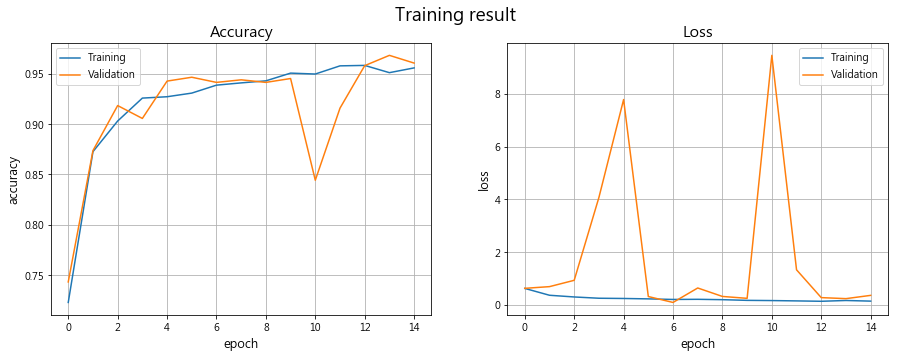

In [12]:
acc_loss(hist, './images/Alexnet_32.png')

In [10]:
score = model.evaluate(test_generator, verbose=1)
print('AlexNet - Test loss:', score[0])
print('AlexNet - Test accuracy:', score[2])
predict = np.ravel(model.predict_classes(test_generator, batch_size=None, verbose=0))

624/624 [==============================] - 8s 13ms/step
AlexNet - Test loss: 0.021849824115633965
AlexNet - Test accuracy: 0.8509615659713745


           AlexNet_32
Accuracy     0.850962
Recall       0.997400
Precision    0.606800
F1           0.754500


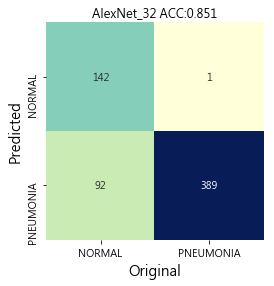

In [11]:
model_result(predict, 'AlexNet_32')

In [8]:
model = load_model('./models/Alexnet_32_last.h5')

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=[tf.keras.metrics.binary_crossentropy, 'accuracy'])

### VGG19

In [15]:
from keras.applications.vgg19 import VGG19

In [16]:
model = Sequential()

vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = False

model.add(vgg_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=[tf.keras.metrics.binary_crossentropy,'accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [17]:
np.random.seed(101)
# earlystop = EarlyStopping(monitor='val_acc', patience=5, mode='max', verbose=1)
model_ckpt = ModelCheckpoint(filepath='./models/Vgg19_32.h5', monitor='val_acc', save_best_only=True)

start = time.time()

model_vgg19 = model.fit(train_generator,
                        epochs=15,
                        validation_data=val_generator,
                        callbacks=[model_ckpt])

end = time.time()
print('\nVGG19 took {0} seconds.'.format(end - start))

model.save('./models/Vgg19_32_last.h5')

history_vgg19 = pd.DataFrame(model_vgg19.history)
with open('./history/Vgg19_32_hist.json', 'w') as f:
    history_vgg19.to_json(f)

Epoch 1/15
139/139 [==============================] - 122s 877ms/step - loss: 0.4283 - binary_crossentropy: 0.4287 - accuracy: 0.8288 - val_loss: 0.9285 - val_binary_crossentropy: 0.4546 - val_accuracy: 0.8708
Epoch 2/15
139/139 [==============================] - 100s 717ms/step - loss: 0.3008 - binary_crossentropy: 0.3015 - accuracy: 0.8924 - val_loss: 0.5346 - val_binary_crossentropy: 0.2917 - val_accuracy: 0.9092
Epoch 3/15
139/139 [==============================] - 104s 751ms/step - loss: 0.2685 - binary_crossentropy: 0.2685 - accuracy: 0.9111 - val_loss: 0.1187 - val_binary_crossentropy: 0.1856 - val_accuracy: 0.9476
Epoch 4/15
139/139 [==============================] - 105s 757ms/step - loss: 0.2381 - binary_crossentropy: 0.2379 - accuracy: 0.9251 - val_loss: 0.2298 - val_binary_crossentropy: 0.1541 - val_accuracy: 0.9578
Epoch 5/15
139/139 [==============================] - 103s 744ms/step - loss: 0.2191 - binary_crossentropy: 0.2186 - accuracy: 0.9344 - val_loss: 0.9367 - val_b

In [18]:
hist = model_vgg19.history
print('Average Training Accuracy', np.average(hist['accuracy']))
print('Average Validation Accuracy', np.average(hist['val_accuracy']))

Average Training Accuracy 0.9375131
Average Validation Accuracy 0.9533674359321594


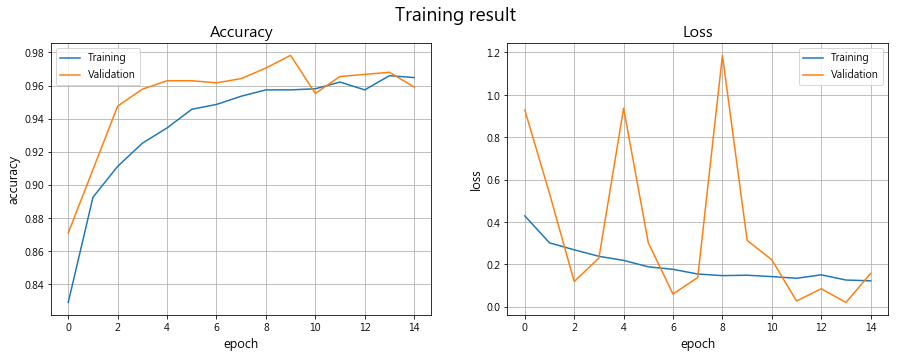

In [19]:
acc_loss(hist, './images/Vgg19_32.png')

In [15]:
score = model.evaluate(test_generator, verbose=1)
print('Vgg19 - Test loss:', score[0])
print('Vgg19 - Test accuracy:', score[2])
predict = (model.predict_classes(test_generator, batch_size = None, verbose=0)).ravel()

624/624 [==============================] - 13s 21ms/step
Vgg19 - Test loss: 0.03689192980527878
Vgg19 - Test accuracy: 0.9006410241127014


           Vgg19_32
Accuracy   0.900641
Recall     0.987200
Precision  0.756400
F1         0.856500


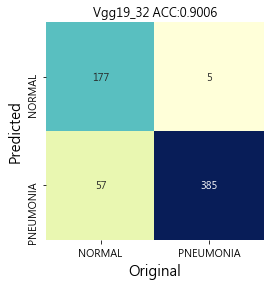

In [16]:
model_result(predict, 'Vgg19_32')

In [13]:
model = load_model('./models/Vgg19_32_last.h5')

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=[tf.keras.metrics.binary_crossentropy,'accuracy'])